# Trabajo Final - Redes Neuronales

## Importo las librerias necesarias


In [9]:
from autoencoder import *
from clasificador import *

## Red neuronal autoencoder convolucional de varias capas

### Importo data set

In [23]:
transform = transforms.Compose([transforms.ToTensor()])

# Download and load the training data
train_set_orig = datasets.FashionMNIST(
    'MNIST_data/', download=True, train=True,  transform=transform)
valid_set_orig = datasets.FashionMNIST(
    'MNIST_data/', download=True, train=False, transform=transform)

100%|██████████| 26421880/26421880 [00:03<00:00, 7548781.01it/s] 


Extracting MNIST_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to MNIST_data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 120306008.32it/s]

Extracting MNIST_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to MNIST_data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 2335363.92it/s]


Extracting MNIST_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to MNIST_data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 55364812.80it/s]

Extracting MNIST_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST_data/FashionMNIST/raw



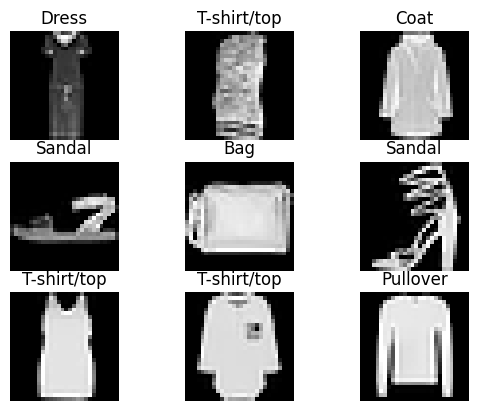

In [24]:
figure = plt.figure()
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    j = torch.randint(len(train_set_orig), size=(1,)).item()
    image, label = train_set_orig[j]
    figure.add_subplot(rows, cols, i)
    plt.title(train_set_orig.classes[label])
    plt.axis("off")
    plt.imshow(image.squeeze(), cmap="gray")
plt.show()

### Creo data set personalizado

In [25]:
train_set = CustomDataset(train_set_orig)
valid_set = CustomDataset(valid_set_orig)

### Parte 1: red autoencoder

In [26]:
class Autoencoder(nn.Module):
    def __init__(self, n, p=0.2):
        super(Autoencoder, self).__init__()
        self.flatten = nn.Flatten()
        self.encoder = nn.Sequential(
            # Convolucional 1
            nn.Conv2d(1, 16, kernel_size=3),  # 1x28x28 -> 16x26x26
            nn.ReLU(),
            nn.Dropout(p),
            nn.MaxPool2d(2),  # 16x26x26 -> 16x13x13
            # Convolucional 2
            nn.Conv2d(16, 32, kernel_size=3),  # 16x13x13 -> 32x11x11
            nn.ReLU(),
            nn.Dropout(p),
            nn.MaxPool2d(2, 2),  # 32x11x11 -> 32x5x5
            # Linear
            nn.Flatten(),  # 32x5x5 -> 32*5*5
            nn.Linear(32*5*5, n),  # fully connected 32*5*5 -> n
            nn.ReLU(),
            nn.Dropout(p)
        )
        self.decoder = nn.Sequential(
            # Linear
            nn.Linear(n, 32*5*5),  # fully connected n -> 32*5*5
            nn.ReLU(),
            nn.Dropout(p),
            nn.Unflatten(1, (32, 5, 5)),  # 32*5*5 -> 32x5x5
            # Convolucional transpose (de la segunda convolucional)
            nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2,
                               output_padding=1),  # 32x5x5 -> 16x13x13
            nn.ReLU(),
            nn.Dropout(p),
            # Convolucional transpose (de la primera convolucional)
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2,
                               output_padding=1),  # 16x13x13 -> 1x28x28
            nn.Sigmoid(),
            nn.Dropout(p)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

## Modelo sin entrenar

In [27]:
# 2.6)
n = 64
p = 0.2
autoencoder_conv = Autoencoder(n, p)
model = autoencoder_conv

In [28]:
autoencoder_conv.encoder

Sequential(
  (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU()
  (2): Dropout(p=0.2, inplace=False)
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (5): ReLU()
  (6): Dropout(p=0.2, inplace=False)
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Flatten(start_dim=1, end_dim=-1)
  (9): Linear(in_features=800, out_features=64, bias=True)
  (10): ReLU()
  (11): Dropout(p=0.2, inplace=False)
)

In [29]:
autoencoder_conv.decoder

Sequential(
  (0): Linear(in_features=64, out_features=800, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.2, inplace=False)
  (3): Unflatten(dim=1, unflattened_size=(32, 5, 5))
  (4): ConvTranspose2d(32, 16, kernel_size=(4, 4), stride=(2, 2), output_padding=(1, 1))
  (5): ReLU()
  (6): Dropout(p=0.2, inplace=False)
  (7): ConvTranspose2d(16, 1, kernel_size=(3, 3), stride=(2, 2), output_padding=(1, 1))
  (8): Sigmoid()
  (9): Dropout(p=0.2, inplace=False)
)

In [30]:
def batch(x):
    return x.unsqueeze(0)  # 28x28 -> 1x28x28


def unbatch(x):
    return x.squeeze().detach().cpu().numpy()  # 1x28x28 -> 28x28

In [31]:
image, _ = train_set[0]
pred = model(batch(image))
print(image.size())
print(unbatch(pred).shape)
print(pred.size())
print(unbatch(pred).shape)

torch.Size([1, 28, 28])
(28, 28)
torch.Size([1, 1, 28, 28])
(28, 28)


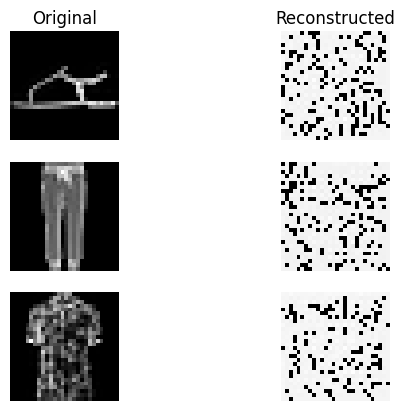

In [32]:
# miramos que imagene predice el modelo sin entrenar
figure = plt.figure()
rows, cols = 3, 2
i = 0
for row in range(1, rows + 1):
    j = torch.randint(len(train_set), size=(1,)).item()
    i += 1
    image, _ = train_set[j]
    figure.add_subplot(rows, cols, i)
    if row == 1:
        plt.title('Original')
    plt.axis("off")
    plt.imshow(image.squeeze(), cmap="gray")
    i += 1
    figure.add_subplot(rows, cols, i)
    if row == 1:
        plt.title('Reconstructed')
    plt.axis("off")
    image_pred = unbatch(model(batch(image)))
    plt.imshow(image_pred.squeeze(), cmap="gray")
plt.show()

## Parte 2: entrenenado el autoencoder

### Modelo Base

In [33]:
indices = torch.randint(len(valid_set), size=(3,))
indices

tensor([4578, 6251,  273])

Epoch 1
-------------------------------
batch=0 loss=0.248406  muestras-procesadas:[    0/60000]
batch=100 loss=0.133377  muestras-procesadas:[10000/60000]
batch=200 loss=0.112006  muestras-procesadas:[20000/60000]
batch=300 loss=0.105674  muestras-procesadas:[30000/60000]
batch=400 loss=0.095934  muestras-procesadas:[40000/60000]
batch=500 loss=0.096420  muestras-procesadas:[50000/60000]
Valid Error: Avg loss: 0.059950 

Valid Error: Avg loss: 0.059935 

Epoch 2
-------------------------------
batch=0 loss=0.084272  muestras-procesadas:[    0/60000]
batch=100 loss=0.085529  muestras-procesadas:[10000/60000]
batch=200 loss=0.084954  muestras-procesadas:[20000/60000]
batch=300 loss=0.081237  muestras-procesadas:[30000/60000]
batch=400 loss=0.080001  muestras-procesadas:[40000/60000]
batch=500 loss=0.081394  muestras-procesadas:[50000/60000]
Valid Error: Avg loss: 0.057247 

Valid Error: Avg loss: 0.057267 

Epoch 3
-------------------------------
batch=0 loss=0.079774  muestras-procesad

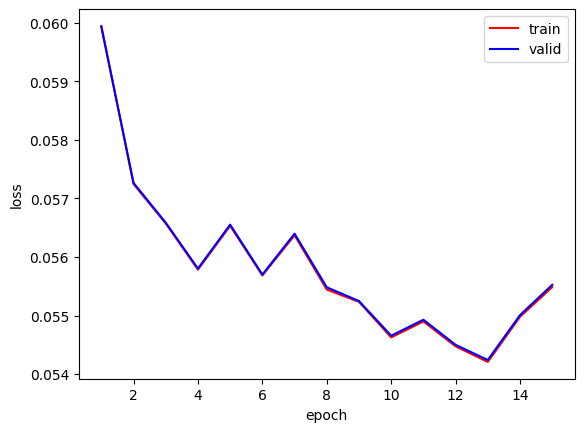

In [34]:
model_orig = model_generator(
    Autoencoder, 64, 0.2, 15, 100, 'Adam', 1e-3, train_set, valid_set)

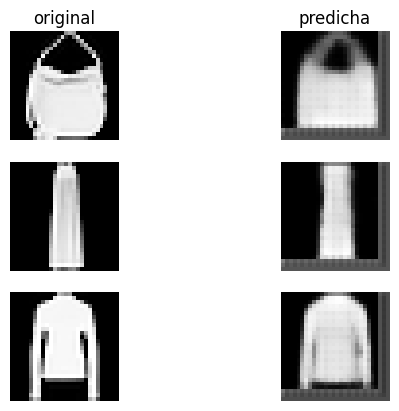

In [35]:
test_model(model_orig, valid_set, indices)

## Variar algunos parametros

### vario dropout

Epoch 1
-------------------------------
batch=0 loss=0.414852  muestras-procesadas:[    0/60000]
batch=100 loss=0.234818  muestras-procesadas:[10000/60000]
batch=200 loss=0.211456  muestras-procesadas:[20000/60000]
batch=300 loss=0.178934  muestras-procesadas:[30000/60000]
batch=400 loss=0.185072  muestras-procesadas:[40000/60000]
batch=500 loss=0.177383  muestras-procesadas:[50000/60000]
Valid Error: Avg loss: 0.100107 

Valid Error: Avg loss: 0.099979 

Epoch 2
-------------------------------
batch=0 loss=0.150969  muestras-procesadas:[    0/60000]
batch=100 loss=0.148230  muestras-procesadas:[10000/60000]
batch=200 loss=0.160875  muestras-procesadas:[20000/60000]
batch=300 loss=0.149673  muestras-procesadas:[30000/60000]
batch=400 loss=0.139677  muestras-procesadas:[40000/60000]
batch=500 loss=0.139660  muestras-procesadas:[50000/60000]
Valid Error: Avg loss: 0.102121 

Valid Error: Avg loss: 0.102128 

Epoch 3
-------------------------------
batch=0 loss=0.147847  muestras-procesad

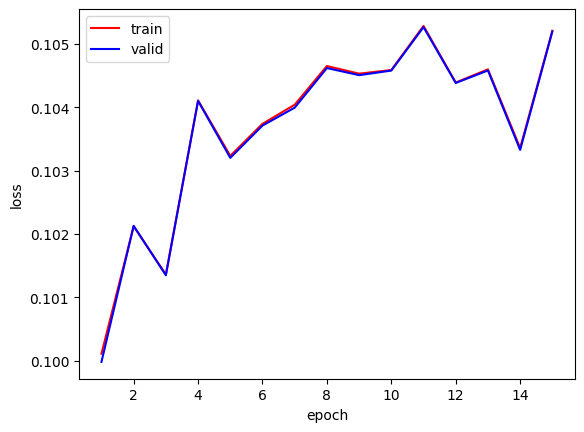

In [37]:
model_drop05 = model_generator(
    Autoencoder, 64, 0.5, 15, 100, 'Adam', 1e-3, train_set, valid_set)

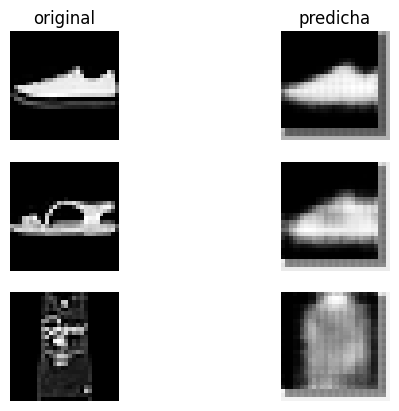

In [38]:
test_model(model_drop05, valid_set)

Epoch 1
-------------------------------
batch=0 loss=0.186977  muestras-procesadas:[    0/60000]
batch=100 loss=0.091044  muestras-procesadas:[10000/60000]
batch=200 loss=0.080818  muestras-procesadas:[20000/60000]
batch=300 loss=0.067842  muestras-procesadas:[30000/60000]
batch=400 loss=0.066667  muestras-procesadas:[40000/60000]
batch=500 loss=0.061628  muestras-procesadas:[50000/60000]
Valid Error: Avg loss: 0.045841 

Valid Error: Avg loss: 0.045913 

Epoch 2
-------------------------------
batch=0 loss=0.063794  muestras-procesadas:[    0/60000]
batch=100 loss=0.061928  muestras-procesadas:[10000/60000]
batch=200 loss=0.060132  muestras-procesadas:[20000/60000]
batch=300 loss=0.056955  muestras-procesadas:[30000/60000]
batch=400 loss=0.058374  muestras-procesadas:[40000/60000]
batch=500 loss=0.057521  muestras-procesadas:[50000/60000]
Valid Error: Avg loss: 0.042225 

Valid Error: Avg loss: 0.042327 

Epoch 3
-------------------------------
batch=0 loss=0.058214  muestras-procesad

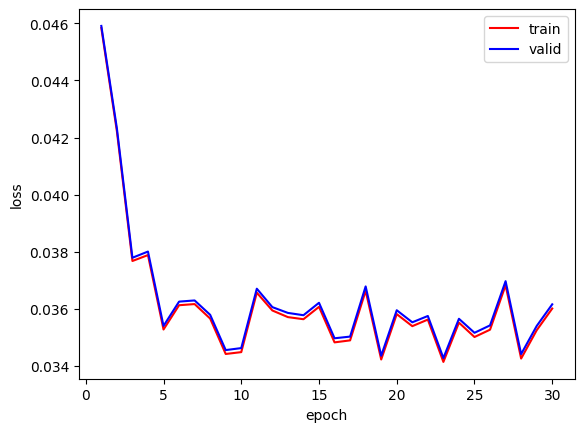

In [39]:
model_64_drop01 = model_generator(
    Autoencoder, 64, 0.1, 30, 100, 'Adam', 1e-3, train_set, valid_set)

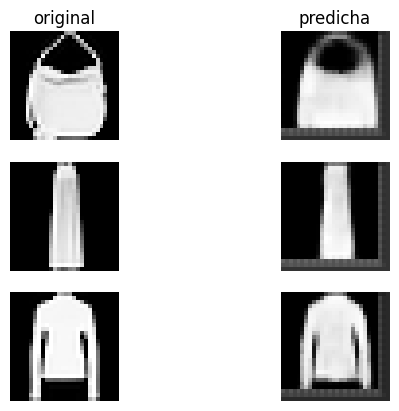

In [40]:
test_model(model_64_drop01, valid_set, indices)

### Variando optimizador

Epoch 1
-------------------------------
batch=0 loss=0.218516  muestras-procesadas:[    0/60000]
batch=100 loss=0.216870  muestras-procesadas:[10000/60000]
batch=200 loss=0.207870  muestras-procesadas:[20000/60000]
batch=300 loss=0.207591  muestras-procesadas:[30000/60000]
batch=400 loss=0.210771  muestras-procesadas:[40000/60000]
batch=500 loss=0.203700  muestras-procesadas:[50000/60000]
Valid Error: Avg loss: 0.151387 

Valid Error: Avg loss: 0.150712 

Epoch 2
-------------------------------
batch=0 loss=0.204142  muestras-procesadas:[    0/60000]
batch=100 loss=0.197582  muestras-procesadas:[10000/60000]
batch=200 loss=0.196089  muestras-procesadas:[20000/60000]
batch=300 loss=0.192579  muestras-procesadas:[30000/60000]
batch=400 loss=0.198548  muestras-procesadas:[40000/60000]
batch=500 loss=0.188141  muestras-procesadas:[50000/60000]
Valid Error: Avg loss: 0.145059 

Valid Error: Avg loss: 0.144418 

Epoch 3
-------------------------------
batch=0 loss=0.190720  muestras-procesad

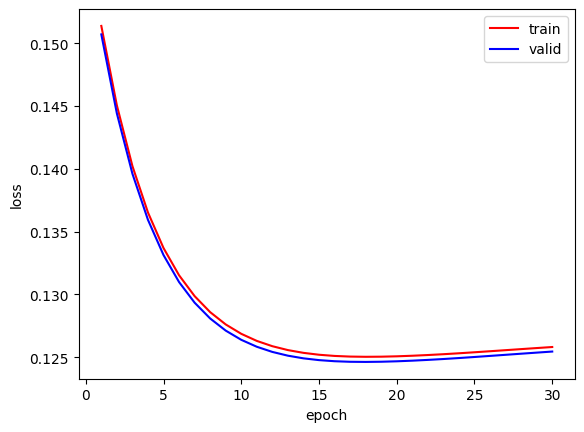

In [41]:
model_drop01_sgd = model_generator(
    Autoencoder, 64, 0.2, 30, 100, 'SGD', 1e-3, train_set, valid_set)

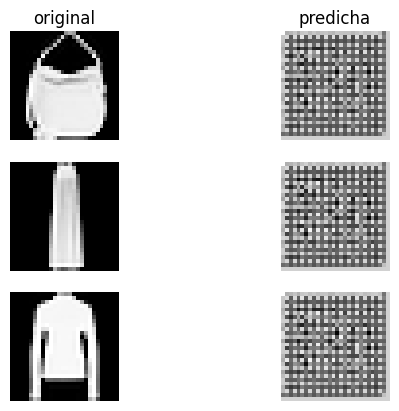

In [42]:
test_model(model_drop01_sgd, valid_set, indices)

## Parte 3: Definiendo un clasificador convolucional reutilizando el encoder

In [47]:
import copy


class Classifier_Conv(nn.Module):
    def __init__(self, n, encoder, p=0.2):
        super(Classifier_Conv, self).__init__()
        self.flatten = nn.Flatten()
        self.encoder = copy.deepcopy(encoder)
        self.classifier = nn.Sequential(
            # Linear
            nn.Linear(n, 10),  # fully connected n -> 32*5*5
            nn.ReLU(),
            nn.Dropout(p)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.classifier(x)
        return x

### clasificador usando el modelo original

Epoch 1
-------------------------------
batch=0 loss=2.598214  muestras-procesadas:[    0/60000]
batch=100 loss=1.439497  muestras-procesadas:[10000/60000]
batch=200 loss=0.974367  muestras-procesadas:[20000/60000]
batch=300 loss=1.050709  muestras-procesadas:[30000/60000]
batch=400 loss=1.016498  muestras-procesadas:[40000/60000]
batch=500 loss=1.001883  muestras-procesadas:[50000/60000]
Test Error: 
 Accuracy: 83.4%, Avg loss: 0.787585 

Test Error: 
 Accuracy: 82.5%, Avg loss: 0.803904 

Epoch 2
-------------------------------
batch=0 loss=0.824489  muestras-procesadas:[    0/60000]
batch=100 loss=0.902155  muestras-procesadas:[10000/60000]
batch=200 loss=0.925009  muestras-procesadas:[20000/60000]
batch=300 loss=0.991735  muestras-procesadas:[30000/60000]
batch=400 loss=0.910830  muestras-procesadas:[40000/60000]
batch=500 loss=0.915164  muestras-procesadas:[50000/60000]
Test Error: 
 Accuracy: 85.6%, Avg loss: 0.701759 

Test Error: 
 Accuracy: 84.5%, Avg loss: 0.722498 

Epoch 3


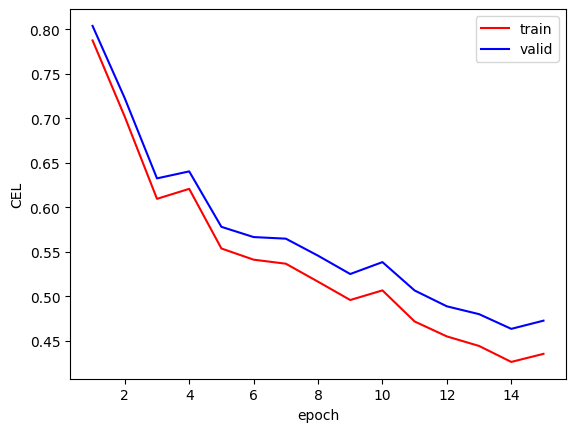

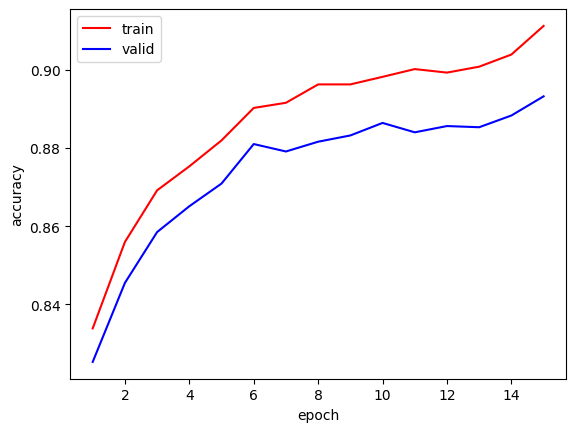

/home/kmansilla/redes-neuronales-trabajos/TP3/clasificador.py:180: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.int8)


              precision    recall  f1-score   support

     T-Shirt       0.83      0.86      0.84      1000
     Trouser       0.99      0.97      0.98      1000
    Pullover       0.84      0.83      0.84      1000
       Dress       0.90      0.88      0.89      1000
        Coat       0.81      0.84      0.83      1000
      Sandal       0.98      0.97      0.98      1000
       Shirt       0.69      0.68      0.68      1000
     Sneaker       0.94      0.97      0.95      1000
         Bag       0.99      0.96      0.98      1000
  Ankle Boot       0.98      0.95      0.97      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



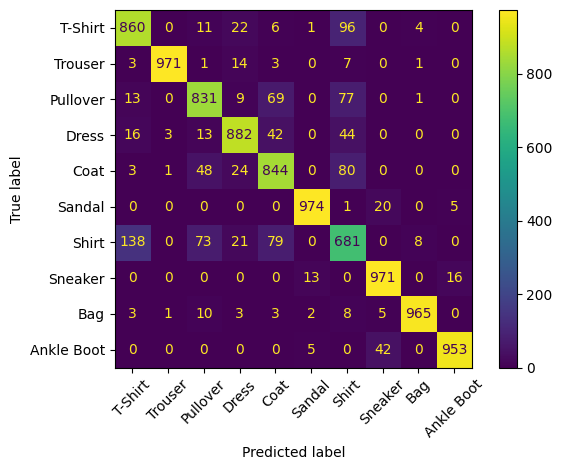

In [48]:
model_classifier_orig = classifier_generator(
    Classifier_Conv, 64, model_orig, 0.2, 15, 100, 'Adam', 1e-3, train_set_orig, valid_set_orig)

## Parte 4:

## Entrenando solo la capa clasificadora

Epoch 1
-------------------------------
batch=0 loss=2.514926  muestras-procesadas:[    0/60000]
batch=100 loss=1.849710  muestras-procesadas:[10000/60000]
batch=200 loss=1.459350  muestras-procesadas:[20000/60000]
batch=300 loss=1.374118  muestras-procesadas:[30000/60000]
batch=400 loss=1.553934  muestras-procesadas:[40000/60000]
batch=500 loss=1.374865  muestras-procesadas:[50000/60000]
Test Error: 
 Accuracy: 76.2%, Avg loss: 1.174105 

Test Error: 
 Accuracy: 75.8%, Avg loss: 1.188187 

Epoch 2
-------------------------------
batch=0 loss=1.103180  muestras-procesadas:[    0/60000]
batch=100 loss=1.161595  muestras-procesadas:[10000/60000]
batch=200 loss=1.062896  muestras-procesadas:[20000/60000]
batch=300 loss=1.399010  muestras-procesadas:[30000/60000]
batch=400 loss=1.282866  muestras-procesadas:[40000/60000]
batch=500 loss=1.331785  muestras-procesadas:[50000/60000]
Test Error: 
 Accuracy: 77.8%, Avg loss: 1.078323 

Test Error: 
 Accuracy: 77.2%, Avg loss: 1.093337 

Epoch 3


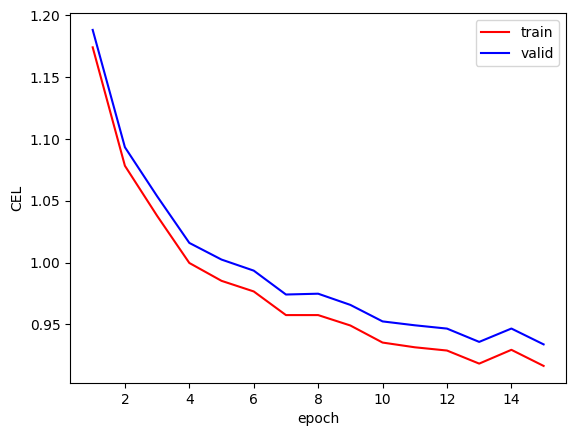

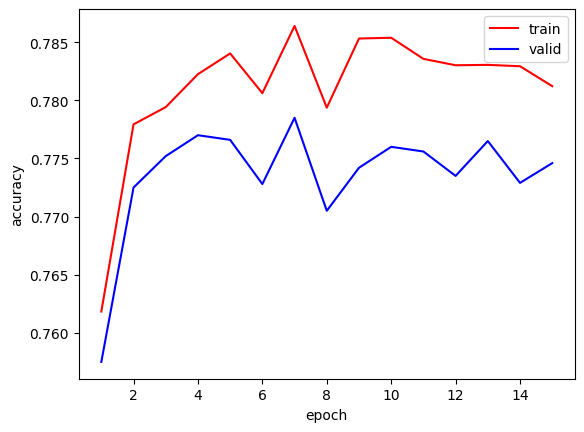

/home/kmansilla/redes-neuronales-trabajos/TP3/clasificador.py:180: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = inputs.to(device)


              precision    recall  f1-score   support

     T-Shirt       0.70      0.82      0.75      1000
     Trouser       0.99      0.93      0.96      1000
    Pullover       0.56      0.77      0.65      1000
       Dress       0.82      0.76      0.79      1000
        Coat       0.72      0.54      0.61      1000
      Sandal       0.93      0.82      0.87      1000
       Shirt       0.46      0.40      0.43      1000
     Sneaker       0.84      0.88      0.86      1000
         Bag       0.92      0.90      0.90      1000
  Ankle Boot       0.88      0.94      0.91      1000

    accuracy                           0.77     10000
   macro avg       0.78      0.77      0.77     10000
weighted avg       0.78      0.77      0.77     10000



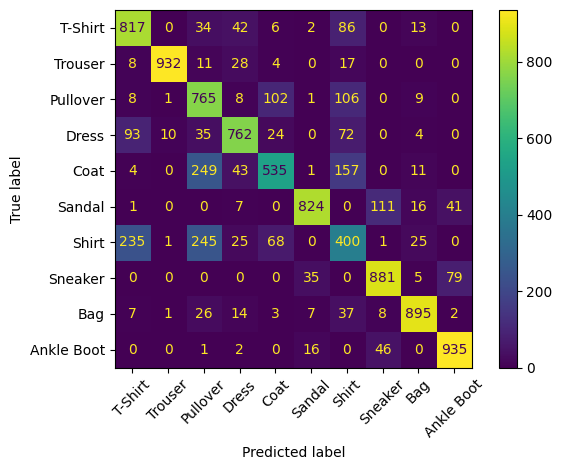

In [50]:
classifier_6 = classifier_generator(Classifier_Conv, 64, model_orig,
                                    0.2, 15, 100, 'Adam classifier', 1e-3, train_set_orig, valid_set_orig)